In [ ]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [ ]:
class MulticlassLogisticRegression:
    def __init__(self, num_classes, learning_rate=0.001, epochs=100000):
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.classifiers = [None] * num_classes
        self.loss_history = []

    def normalize_features(self, X):
        min_vals = X.min(axis=0)
        max_vals = X.max(axis=0)
        X_normalized = (X - min_vals) / (max_vals - min_vals)
        return X_normalized

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def loss_function(self, X, y, w):
        n = len(X)
        S_X = self.sigmoid(np.dot(X, w.T))
        loss = -(np.dot(y, np.log(S_X + 1e-9)) + np.dot(1 - y, np.log(1 - S_X + 1e-9))) / n
        return loss

    def derivatives(self, X, y, w):
        n = len(X)
        S_X = self.sigmoid(np.dot(X, w.T))
        return np.dot(S_X - y, X) / n

    def change_parameters(self, w, derivatives):
        return w - self.learning_rate * derivatives

    def train(self, X, Y):
        random.seed(2023)
        X = self.normalize_features(X)
        X = np.insert(X, 0, 1, axis=1)

        for class_label in range(self.num_classes):
            y_class = (Y == class_label).astype(int)
            w = np.random.random(X.shape[1])

            for epoch in range(self.epochs):
                loss = self.loss_function(X, y_class, w)
                self.loss_history.append(loss)
                derivatives = self.derivatives(X, y_class, w)
                w = self.change_parameters(w, derivatives)

            self.classifiers[class_label] = w

    def predict(self, X):
        X = self.normalize_features(X)
        X = np.insert(X, 0, 1, axis=1)
        probabilities = np.array([self.sigmoid(np.dot(X, w.T)) for w in self.classifiers])
        return np.argmax(probabilities, axis=0)

    def plot_loss(self):
        plt.plot(np.arange(self.epochs), self.loss_history)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Function')
    
    def accuracy_score(y_true, y_pred):
        correct_predictions = np.sum(y_true == y_pred)
        total_predictions = len(y_true)
        accuracy = correct_predictions / total_predictions
        return accuracy



In [ ]:
dataset = pd.read_csv('vc_mariposas_sin_fondo_250_4.csv')
X = np.array(dataset['X'].apply(eval))
X = np.array([np.array(x) for x in X])
Y = dataset['Y'].values
Y = np.array([i - 1 for i in Y])

# Mezcla los datos
X, Y = shuffle(X, Y)#random_state

# Crea una instancia de PCA y conserva 25 componentes principales
pca = PCA(n_components=25)

# Ajusta PCA a los datos y transforma los datos originales
X = pca.fit_transform(X)

# Divide los datos en conjuntos de entrenamiento, evaluación y predicción
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3)
X_eval, X_test, Y_eval, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5)

In [ ]:
num_classes = len(np.unique(Y_train))
model = MulticlassLogisticRegression(num_classes, learning_rate=0.1, epochs=10000)
model.train(X_train, Y_train)

In [ ]:
Y_pred = model.predict(X_eval)
print("Número de datos correctos", (sum(Y_pred == Y_eval)/len(Y_eval))*100)


Número de datos correctos 54.400000000000006


In [ ]:
from sklearn import metrics
import seaborn as sns
def make_confusion_matrix(Y_real, Y_pred, title="Confusion Matrix"):
    cm = metrics.confusion_matrix(Y_real, Y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    dataframe = pd.DataFrame(cmn)

    sns.heatmap(dataframe, annot=True, cbar=False, cmap="Blues")
    plt.title(title), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

    eff = np.nanmean(np.diagonal(cmn))
    return eff

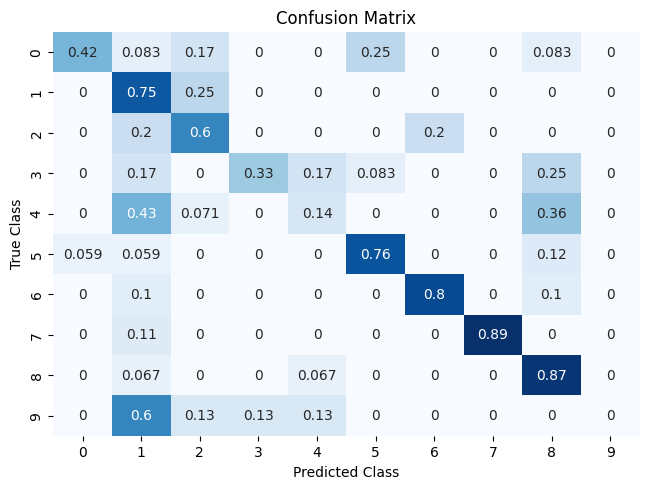

0.5563118580765639

In [ ]:
make_confusion_matrix(Y_eval, Y_pred)

In [ ]:
K = 3  # Reemplaza con el número deseado de pliegues

kf = KFold(n_splits=K, shuffle=True, random_state=2023)  # Puedes ajustar shuffle y random_state según tus necesidades

accuracy_scores = []  # Para almacenar las puntuaciones de precisión de cada pliegue

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Crear una instancia de la clase MulticlassLogisticRegression
    num_classes = len(np.unique(Y_train))  # Reemplaza con el número adecuado de clases
    model = MulticlassLogisticRegression(num_classes=num_classes, learning_rate=0.01, epochs=10000)

    # Entrenar el modelo con los datos de entrenamiento (X_train, Y_train)
    model.train(X_train, Y_train)

    # Realizar predicciones en los datos de prueba (X_test)
    Y_pred = model.predict(X_test)

    # Calcular y almacenar la precisión del modelo en este pliegue
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracy_scores.append(accuracy)

# Calcular la precisión promedio de todos los pliegues
average_accuracy = np.mean(accuracy_scores)
print(f'Precisión promedio de {K}-fold cross-validation: {average_accuracy:.2f}')


Precisión promedio de 3-fold cross-validation: 0.36


In [ ]:
print(accuracy_scores)

[0.35611510791366907, 0.3971119133574007, 0.20938628158844766]
